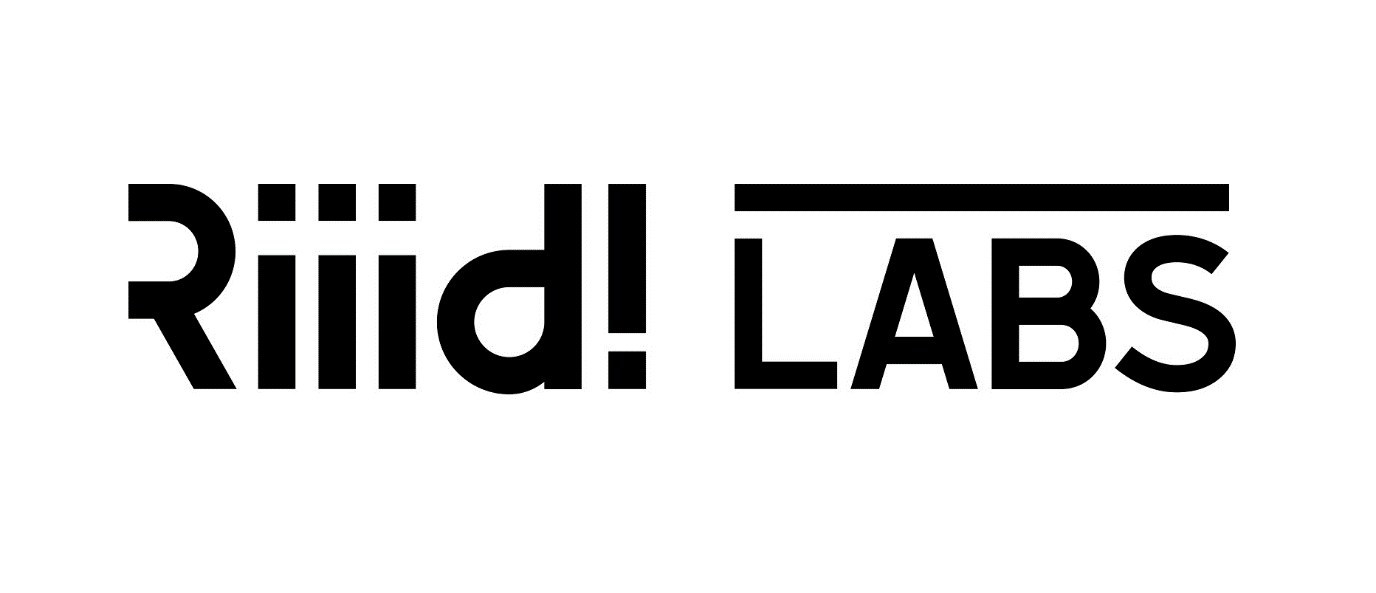

<h1><center><font size="6">Riid! Basic Exploration</font></center></h1>

<h2><center><font size="4">Dataset used: Riid! Answer Correctness Prediction</font></center></h2>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
sns.set_style("white")


plt.style.use("seaborn")

# <a id='1'>Introduction</a>  

In this challenge, our objective is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time (i.e) predict whether students are able to answer their next questions correctly.
<hr>
This is a time-series code competition, you will receive test set data and make predictions with Kaggle's time-series API. Please be sure to review the Time-series API Details section closely. (Which is awesome!! :D)

Check -> https://www.kaggle.com/sohier/competition-api-detailed-introduction

# <a id='2'>Basic Information And Preprocessing</a>

### Loading Data

In [ ]:
%%time
TRAIN_PATH = "../input/riiid-test-answer-prediction/train.csv"
train = pd.read_csv(TRAIN_PATH,low_memory=False, nrows=500000, 
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             })

### Train contains:

<b>row_id</b>: (int64) ID code for the row.

<b>timestamp</b>: (int64) the time between this user interaction and the first event from that user.

<b>user_id</b>: (int32) ID code for the user.

<b>content_id</b>: (int16) ID code for the user interaction

<b>content_type_id</b>: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

<b>task_container_id</b>: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

<b>user_answer</b>: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

<b>answered_correctly</b>: (int8) if the user responded correctly. Read -1 as null, for lectures.

<b>prior_question_elapsed_time</b>: (float32) How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

<b>prior_question_had_explanation</b>: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [ ]:
train = train.query('answered_correctly != -1').reset_index(drop=True) #Dropping null values

In [ ]:
print(f'Train Dataset Dimension: {train.shape}')

In [ ]:
train.info()

In [ ]:
train.describe()

### Missing Data

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
%%time
missing_data(train)

For baseline let the LGBM/XGBoost model can handle the missing values.

In [ ]:
plt.figure(figsize=(15,6))
sns.set_style("white")
sns.kdeplot(train.groupby(by='user_id').count()['row_id'], shade=True, gridsize=30,legend=False)
plt.title("User_id distribution", fontsize = 20)
plt.xlabel('User_id counts', fontsize=12)
plt.ylabel('Probability', fontsize=12);

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (19,7))
sns.set_style("white")
sns.kdeplot(train[train['answered_correctly'] == 1].groupby("user_id").count()['row_id'], shade=True, 
            gridsize=30,legend=True, ax = ax[0], label = "Correct Answer", color = 'g')
plt.ylabel('Probability', fontsize=12);
sns.kdeplot(train[train['answered_correctly'] == 0].groupby("user_id").count()['row_id'], shade=True, 
            gridsize=30,legend=True,ax = ax[1], label = "Wronng Answer", color = 'r' )
plt.ylabel('Probability', fontsize=12);
# plt.show()

sns.set_style("white")
sns.countplot(train["answered_correctly"],palette='PRGn', ax = ax[2])
plt.xlabel("Answered Correctly")
plt.ylabel("Counts")
plt.title("Target Counts", fontsize = 15)
plt.show()

In [ ]:
sns.set_style("white")
sns.kdeplot(train["prior_question_elapsed_time"],shade=True, gridsize=30,legend=False)
plt.title("prior_question_elapsed_time distribution", fontsize = 20)
# plt.xlabel('User_id counts', fontsize=12)
plt.ylabel('Probability', fontsize=12);

In [ ]:
sns.set_style("white")
sns.countplot(train["user_answer"], palette="Set3")
plt.xlabel("User Answers")
plt.ylabel("Counts")
plt.title("User Answer Counts", fontsize = 15)
plt.show()

In [ ]:
sns.set_style("white")
sns.countplot(train["prior_question_had_explanation"], palette="Set3")
plt.xlabel("User Answers",fontsize=12)
plt.ylabel("Counts",fontsize=12)
plt.title("User Answer Counts", fontsize = 15)
plt.show()

In [ ]:
sns.countplot(train['answered_correctly'], hue=train['prior_question_had_explanation'],palette='PRGn')
plt.xlabel("Answered Correctly")
plt.ylabel("Counts")
plt.xlabel('Answered_correctly', fontsize = 13)

In [ ]:
sns.boxenplot(train["answered_correctly"],train["prior_question_elapsed_time"], palette='PRGn')
plt.xlabel("Answered Correctly",fontsize = 13)
plt.xlabel('Answered_correctly', fontsize = 13)

In [ ]:
sns.violinplot(train["user_answer"],train["prior_question_elapsed_time"],palette='PRGn')

# <a id='3'>Benchmark Modeling</a>

In [ ]:
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].map({False : 0,
                                                                                       True: 1})

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate,GridSearchCV, train_test_split

In [ ]:
X = train.drop(['answered_correctly', 'user_answer'], axis=1)
Y = train['answered_correctly']

train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size = 0.3,random_state = 42)

In [ ]:
LGBM = LGBMClassifier( class_weight="balanced", max_depth=-1,metric = 'auc',tree_learner = 'serial',
                     min_data_in_leaf = 80,num_leaves = 50, learning_rate=0.0999,feature_fraction = 0.05,
                     bagging_fraction = 0.4, n_estimators = 190)
LGBM.fit(train_x.values,train_y.values)
pred_train = LGBM.predict_proba(train_x)[:,1]
print("Train ROC_AUC Score: ", roc_auc_score(train_y,pred_train))
pred_test = LGBM.predict_proba(test_x)[:,1]
print("Train ROC_AUC Score: ", roc_auc_score(test_y,pred_test))

In [ ]:
#Training lgbm on whole data

LGBM = LGBMClassifier( class_weight="balanced", max_depth=-1,metric = 'auc',tree_learner = 'serial',
                     min_data_in_leaf = 80,num_leaves = 50, learning_rate=0.0999,feature_fraction = 0.05,
                     bagging_fraction = 0.4, n_estimators = 190)
LGBM.fit(X,Y)
pred_train = LGBM.predict_proba(X)[:,1]
print("Train ROC_AUC Score: ", roc_auc_score(Y,pred_train))

In [ ]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()


for (test_df, sample_prediction_df) in iter_test:
    y_preds = []
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].astype(float)
    X_test = test_df.drop(['prior_group_answers_correct', 'prior_group_responses'], axis=1)

#     for model in models:
#         y_pred = LGBM.predict(X_test)
#         y_preds.append(y_pred)

#     y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = LGBM.predict(X_test)
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

In [ ]:
XGB = XGBClassifier(max_depth = 5,n_estimators = 200)
XGB.fit(train_x.values,train_y.values)
pred_train = XGB.predict_proba(train_x)[:,1]
print("Train ROC_AUC Score: ", roc_auc_score(train_y,pred_train))
pred_test = XGB.predict_proba(test_x)[:,1]
print("Train ROC_AUC Score: ", roc_auc_score(test_y,pred_test))

# Thanks for reading!!  Lot more to come :D

# Updating...